In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading Dataset
file_path = "/content/drive/MyDrive/CSI_7_MAL_2526_Data.xlsx"
df = pd.read_excel(file_path)

print(df.shape)
df.head()


(318, 143)


,PatID,Severity Score,NeutroRegionA_CALC,NeutroRegionC_CALC,NeutroRegionD_CALC,NeutroRegionE_CALC,neutro_perneutro_1_CALC,neutro_pereosino_1_CALC,neutro_perepith_1_CALC,neutro_perother_1_CALC,...,NERRegionF+RegionE_CALC,NERRegionB+RegionE_CALC,NERTotal_CALC,NLRRegionA_CALC,NLRRegionC_CALC,NLRRegionB_CALC,NLRRegionE_CALC,NLRRegionF+RegionE_CALC,NLRRegionB+RegionE_CALC,NLRTotal_CALC
0,ID_001,3.0,183.0,13.0,38.0,1.0,14.855319,7.965174,8.083116,6.244365,...,26.000000,19.500000,1.169154,0.012237,0.029545,0.175926,0.166667,0.078550,0.175676,0.015048
1,ID_002,5.0,1617.0,28.0,4.0,0.0,98.713159,32.372671,8.176349,51.465719,...,4.571429,1.000000,3.414079,0.076421,0.161850,0.078431,0.000000,0.142857,0.078431,0.077117
2,ID_003,3.0,268.0,8.0,65.0,0.0,17.038123,9.425455,6.357759,6.215071,...,6.083333,5.416667,1.240000,0.011443,0.025397,0.055603,0.000000,0.049059,0.055413,0.013690
3,ID_004,4.0,295.0,5.0,56.0,2.0,25.044693,11.019324,6.698129,7.512135,...,2.520000,4.142857,0.864734,0.016013,0.009747,0.061135,0.142857,0.043659,0.062366,0.018021
4,ID_005,5.0,200.0,2.0,16.0,12.0,10.243478,5.881563,4.202329,3.699312,...,3.333333,9.333333,0.280830,0.009029,0.018182,0.181818,0.500000,0.135135,0.250000,0.010280


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Columns: 143 entries, PatID to NLRTotal_CALC
dtypes: float64(142), object(1)
memory usage: 355.4+ KB


In [5]:
# Create a summary table to review the dataset's columns
summary_table = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes.values,
    "Missing Values": df.isna().sum().values,
    "Missing (%)": (df.isna().mean() * 100).round(2).values
})
# Sort the summary table so the columns with the most missing values appear first
summary_table = summary_table.sort_values("Missing Values", ascending=False)

summary_table


,Column,Data Type,Missing Values,Missing (%)
125,PlasmaLymphConnRegionENorm_CALC,float64,16,5.03
118,RegionFRegionENorm_CALC,float64,16,5.03
111,EosinoRegionENorm_CALC,float64,16,5.03
104,NeutroRegionENorm_CALC,float64,16,5.03
2,NeutroRegionA_CALC,float64,15,4.72
...,...,...,...,...
138,NLRRegionB_CALC,float64,15,4.72
141,NLRRegionB+RegionE_CALC,float64,15,4.72
142,NLRTotal_CALC,float64,15,4.72
1,Severity Score,float64,12,3.77


In [6]:
PATIENT_COL = "PatID"
TARGET_COL  = "Severity Score"

# Define predictors = everything except PatID and target
predictor_cols = [c for c in df.columns if c not in [PATIENT_COL, TARGET_COL]]

In [7]:
#   DROP INVALID ROWS
#   Remove missing target Rows
#   Remove rows where all predictors are missing
# ---------------------------
missing_target = df[TARGET_COL].isna().sum()
df = df[df[TARGET_COL].notna()].copy()

all_pred_missing_mask = df[predictor_cols].isna().all(axis=1)
all_pred_missing = int(all_pred_missing_mask.sum())
df = df.loc[~all_pred_missing_mask].copy()

df.reset_index(drop=True, inplace=True)

print(f"Dropped missing target rows: {missing_target}")
print(f"Dropped all-predictor-missing rows: {all_pred_missing}")
print("Cleaned shape:", df.shape)
print("Unique subjects (PatID):", df[PATIENT_COL].nunique())

Dropped missing target rows: 12
Dropped all-predictor-missing rows: 3
Cleaned shape: (303, 143)
Unique subjects (PatID): 106


In [8]:
# Checking Duplicate Rows
duplicate_rows = df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


In [9]:
# Checking Duplicalte Columns
duplicate_columns = df.columns[df.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


In [10]:
df["Severity Score"].value_counts().sort_index()

,count
Severity Score,
0.0,78
1.0,6
2.0,30
3.0,68
4.0,22
5.0,99


In [11]:
# ---------------------------
#    Keep numeric predictors only
#    Mask negative values to NaN (invalid-negative masking)
# ---------------------------
X_raw = df[predictor_cols].copy()

# Keep numeric predictors only
numeric_predictors = X_raw.select_dtypes(include=[np.number]).columns.tolist()
non_numeric = [c for c in X_raw.columns if c not in numeric_predictors]
if non_numeric:
    print("\nNon-numeric predictors dropped:", non_numeric)
X = X_raw[numeric_predictors].copy()

# Mask negative values → NaN (domain sanity)
neg_before = int((X < 0).sum().sum())
X = X.mask(X < 0)
neg_after = int((X < 0).sum().sum())
print(f"\nNegative values masked to NaN: {neg_before} (now remaining negatives: {neg_after})")


Negative values masked to NaN: 2 (now remaining negatives: 0)


In [12]:
# Constant Features Check
constant_features = [
    col for col in numeric_predictors
    if df[col].nunique() <= 1
]

print("Constant features:", constant_features)


Constant features: []


In [13]:
# Create binary target
# Targets
y_reg = df[TARGET_COL].astype(float).values
y_bin = (df[TARGET_COL] >= 3).astype(int).values

# Groups for GroupKFold
groups = df[PATIENT_COL].values

print("\nX shape:", X.shape)
print("Binary class counts (0=low, 1=high):", dict(zip(*np.unique(y_bin, return_counts=True))))


X shape: (303, 141)
Binary class counts (0=low, 1=high): {np.int64(0): np.int64(114), np.int64(1): np.int64(189)}


In [14]:
# ---------------------------
# MISSINGNESS SUMMARY (top 15)
# ---------------------------
missing_summary = pd.DataFrame({
    "Feature": X.columns,
    "Missing": X.isna().sum().values,
    "Missing_%": (X.isna().mean() * 100).round(2).values
}).sort_values("Missing", ascending=False)

print("\nTop 15 missingness features:")
display(missing_summary.head(15))


Top 15 missingness features:


,Feature,Missing,Missing_%
109,EosinoRegionENorm_CALC,1,0.33
102,NeutroRegionENorm_CALC,1,0.33
123,PlasmaLymphConnRegionENorm_CALC,1,0.33
29,epith_pereosino_2_CALC,1,0.33
13,epith_pereosino_1_CALC,1,0.33
116,RegionFRegionENorm_CALC,1,0.33
6,neutro_perepith_1_CALC,0,0.00
5,neutro_pereosino_1_CALC,0,0.00
0,NeutroRegionA_CALC,0,0.00
1,NeutroRegionC_CALC,0,0.00


In [15]:
# Checking Outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outlier_counts = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()
outlier_counts.sort_values(ascending=False).head(10)

,0
NeutroRegionENorm_CALC,63
NLRRegionE_CALC,62
NeutroRegionE_CALC,44
NeutroRegionC_CALC,43
NERRegionA_CALC,42
NeutroRegionD+RegionENorm_CALC,41
NERTotal_CALC,41
NeutroRegionDNorm_CALC,40
NERRegionE_CALC,39
PlasmaLymphConnRegionE_CALC,37


In [16]:
# ---------------------------
# Cross Validation SETUP + SCORING
# ---------------------------

N_SPLITS    = 5
RANDOM_STATE = 42
gkf = GroupKFold(n_splits=N_SPLITS)

# Regression scoring (note: sklearn returns negative MAE for "neg_mean_absolute_error")
reg_scoring = {"mae": "neg_mean_absolute_error"}

# Sensitivity & Specificity (binary)
def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

clf_scoring = {
    "acc": "accuracy",
    "roc": "roc_auc",
    "sens": make_scorer(sensitivity_score),
    "spec": make_scorer(specificity_score),
}

def run_cv(estimator, X, y, groups, scoring_dict, cv):
    """
    Runs cross_validate and returns a dict: metric -> (mean, std).
    Uses error_score=np.nan so folds with issues don't crash the run.
    """
    res = cross_validate(
        estimator,
        X, y,
        groups=groups,
        cv=cv,
        scoring=scoring_dict,
        n_jobs=1,              # safer than nested parallelism
        error_score=np.nan
    )

    out = {}
    for k, v in res.items():
        if k.startswith("test_"):
            m = k.replace("test_", "")
            if m == "mae":
                # Convert neg MAE to positive MAE
                out[m] = (float(np.nanmean(-v)), float(np.nanstd(-v)))
            else:
                out[m] = (float(np.nanmean(v)), float(np.nanstd(v)))
    return out

def fmt(mean_std):
    mean, std = mean_std
    return f"{mean:.4f} ± {std:.4f}"

In [17]:
# ============================================================
# MODELS — ALL FEATURES
# ============================================================

# Regression models (all features)
pipe_ridge_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

pipe_svr_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1))
])

pipe_rf_reg_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=300,        # keep runtime reasonable
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Classification models (all features)
pipe_logreg_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=5000,
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])

pipe_svc_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=10,
        probability=False,       # faster; roc_auc uses decision_function
        random_state=RANDOM_STATE
    ))
])

pipe_rf_clf_all = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("\n====================")
print("ALL FEATURES — CV")
print("====================")

reg_all = {
    "Ridge": run_cv(pipe_ridge_all, X, y_reg, groups, reg_scoring, gkf),
    "SVR": run_cv(pipe_svr_all, X, y_reg, groups, reg_scoring, gkf),
    "RandomForest": run_cv(pipe_rf_reg_all, X, y_reg, groups, reg_scoring, gkf),
}

clf_all = {
    "LogReg": run_cv(pipe_logreg_all, X, y_bin, groups, clf_scoring, gkf),
    "SVC": run_cv(pipe_svc_all, X, y_bin, groups, clf_scoring, gkf),
    "RandomForest": run_cv(pipe_rf_clf_all, X, y_bin, groups, clf_scoring, gkf),
}

print("\nRegression (MAE):")
for name, m in reg_all.items():
    print(f"  {name:12s}  {fmt(m['mae'])}")

print("\nClassification:")
for name, m in clf_all.items():
    print(f"  {name:12s}  Acc {fmt(m['acc'])} | ROC {fmt(m['roc'])} | Sens {fmt(m['sens'])} | Spec {fmt(m['spec'])}")



ALL FEATURES — CV

Regression (MAE):
  Ridge         1.0832 ± 0.0946
  SVR           0.9277 ± 0.0797
  RandomForest  0.6929 ± 0.0340

Classification:
  LogReg        Acc 0.9009 ± 0.0236 | ROC 0.9434 ± 0.0180 | Sens 0.9108 ± 0.0414 | Spec 0.8898 ± 0.0738
  SVC           Acc 0.8976 ± 0.0481 | ROC 0.9469 ± 0.0256 | Sens 0.9260 ± 0.0251 | Spec 0.8541 ± 0.0960
  RandomForest  Acc 0.9273 ± 0.0137 | ROC 0.9827 ± 0.0044 | Sens 0.9271 ± 0.0455 | Spec 0.9343 ± 0.0514


In [18]:
# ============================================================
# MODELS 10 FEATURES (SELECTION INSIDE CV)
# Using SelectFromModel(RandomForest...) within Pipeline
# ============================================================

# Feature selectors (fit inside each fold)
selector_reg = SelectFromModel(
    RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    max_features=10,
    threshold=-np.inf
)

selector_clf = SelectFromModel(
    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    max_features=10,
    threshold=-np.inf
)

# Regression (<=10)
pipe_ridge_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_reg),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

pipe_svr_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_reg),
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1))
])

pipe_rf_reg_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_reg),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
])

# Classification (10)
pipe_logreg_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_clf),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear", random_state=RANDOM_STATE))
])

pipe_svc_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_clf),
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", C=10, probability=False, random_state=RANDOM_STATE))
])

pipe_rf_clf_10 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", selector_clf),
    ("model", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
])

print("\n====================")
print("<=10 FEATURES — CV")
print("====================")

reg_10 = {
    "Ridge": run_cv(pipe_ridge_10, X, y_reg, groups, reg_scoring, gkf),
    "SVR": run_cv(pipe_svr_10, X, y_reg, groups, reg_scoring, gkf),
    "RandomForest": run_cv(pipe_rf_reg_10, X, y_reg, groups, reg_scoring, gkf),
}

clf_10 = {
    "LogReg": run_cv(pipe_logreg_10, X, y_bin, groups, clf_scoring, gkf),
    "SVC": run_cv(pipe_svc_10, X, y_bin, groups, clf_scoring, gkf),
    "RandomForest": run_cv(pipe_rf_clf_10, X, y_bin, groups, clf_scoring, gkf),
}

print("\nRegression (MAE):")
for name, m in reg_10.items():
    print(f"  {name:12s}  {fmt(m['mae'])}")

print("\nClassification:")
for name, m in clf_10.items():
    print(f"  {name:12s}  Acc {fmt(m['acc'])} | ROC {fmt(m['roc'])} | Sens {fmt(m['sens'])} | Spec {fmt(m['spec'])}")




<=10 FEATURES — CV

Regression (MAE):
  Ridge         1.1919 ± 0.0946
  SVR           0.7401 ± 0.0600
  RandomForest  0.6826 ± 0.0416

Classification:
  LogReg        Acc 0.8977 ± 0.0123 | ROC 0.9759 ± 0.0077 | Sens 0.8569 ± 0.0277 | Spec 0.9679 ± 0.0393
  SVC           Acc 0.9175 ± 0.0183 | ROC 0.9755 ± 0.0082 | Sens 0.8998 ± 0.0351 | Spec 0.9516 ± 0.0456
  RandomForest  Acc 0.9306 ± 0.0341 | ROC 0.9811 ± 0.0075 | Sens 0.9423 ± 0.0462 | Spec 0.9146 ± 0.0335


In [19]:
# ============================================================
# RESULT TABLES
# ============================================================

# Table 1 (Regression)
table1 = pd.DataFrame({
    "Model": list(reg_all.keys()),
    "All features (MAE)": [fmt(reg_all[m]["mae"]) for m in reg_all],
    "<=10 features (MAE)": [fmt(reg_10[m]["mae"]) for m in reg_10],
})
print("\nTABLE 1 — Regression (MAE):")
display(table1)

# Table 2 (Classification)
def clf_row(name, metrics):
    return {
        "Model": name,
        "Accuracy": fmt(metrics["acc"]),
        "ROC-AUC": fmt(metrics["roc"]),
        "Sensitivity": fmt(metrics["sens"]),
        "Specificity": fmt(metrics["spec"]),
    }

table2_all = pd.DataFrame([clf_row(k, v) for k, v in clf_all.items()])
table2_all.insert(1, "Setting", "All features")

table2_10 = pd.DataFrame([clf_row(k, v) for k, v in clf_10.items()])
table2_10.insert(1, "Setting", "10 features")

table2 = pd.concat([table2_all, table2_10], ignore_index=True)

print("\nTABLE 2 — Classification:")
display(table2)


TABLE 1 — Regression (MAE):


,Model,All features (MAE),<=10 features (MAE)
0,Ridge,1.0832 ± 0.0946,1.1919 ± 0.0946
1,SVR,0.9277 ± 0.0797,0.7401 ± 0.0600
2,RandomForest,0.6929 ± 0.0340,0.6826 ± 0.0416



TABLE 2 — Classification:


,Model,Setting,Accuracy,ROC-AUC,Sensitivity,Specificity
0,LogReg,All features,0.9009 ± 0.0236,0.9434 ± 0.0180,0.9108 ± 0.0414,0.8898 ± 0.0738
1,SVC,All features,0.8976 ± 0.0481,0.9469 ± 0.0256,0.9260 ± 0.0251,0.8541 ± 0.0960
2,RandomForest,All features,0.9273 ± 0.0137,0.9827 ± 0.0044,0.9271 ± 0.0455,0.9343 ± 0.0514
3,LogReg,10 features,0.8977 ± 0.0123,0.9759 ± 0.0077,0.8569 ± 0.0277,0.9679 ± 0.0393
4,SVC,10 features,0.9175 ± 0.0183,0.9755 ± 0.0082,0.8998 ± 0.0351,0.9516 ± 0.0456
5,RandomForest,10 features,0.9306 ± 0.0341,0.9811 ± 0.0075,0.9423 ± 0.0462,0.9146 ± 0.0335


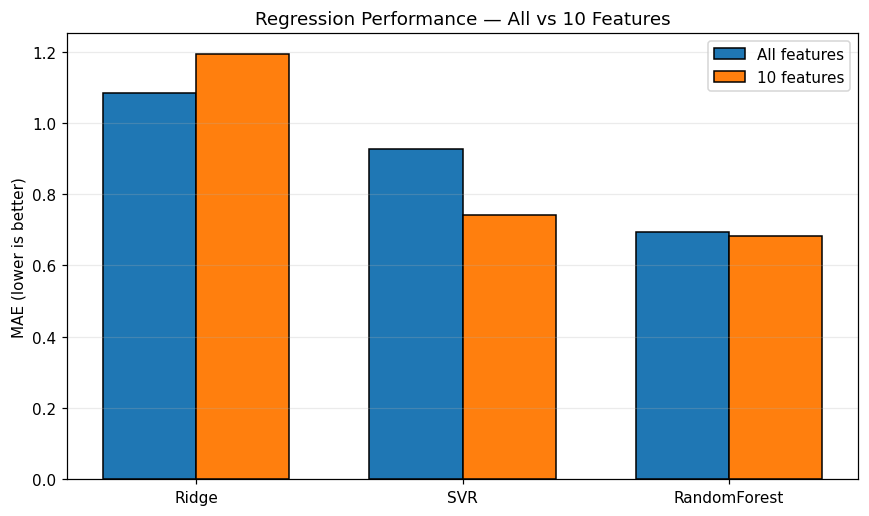

In [20]:
# Regression MAE bar plot
models = list(reg_all.keys())
mae_all = [reg_all[m]["mae"][0] for m in models]
mae_10v = [reg_10[m]["mae"][0] for m in models]

x = np.arange(len(models))
w = 0.35

plt.figure(figsize=(8, 4.8), dpi=110)
plt.bar(x - w/2, mae_all, width=w, edgecolor="black", label="All features")
plt.bar(x + w/2, mae_10v, width=w, edgecolor="black", label="10 features")
plt.xticks(x, models)
plt.ylabel("MAE (lower is better)")
plt.title("Regression Performance — All vs 10 Features")
plt.grid(True, axis="y", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()
